# Human body motion for in-home physiotherapy

In [1]:
import os
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
import seaborn as sns
import statistics as st
import glob

## Getting started with OpenPose

link GitHub: GitHub - OpenKinect/libfreenect: Drivers and libraries for the Xbox Kinect device on Windows, Linux, and OS X
cd D:\Special_Project\openpose
bin\OpenPoseDemo.exe --image_dir examples\media\  --write_json output_json_folder/
* 1 file .json by images: --image_dir
* 1 file .json by video: --video


## Read the output

In [2]:
#---------------------------- Define by user ----------------------------#
def path_file(repository, file):
    path=os.path.join(repository, file)
    return path
#------------------------------------------------------------------------#

In [3]:
path='D:\Special_Project\openpose\output_json_folder\Train\Ludo'
file='WIN_20220928_09_32_59_Pro_keypoints.json'


path_json=path_file(path,file)
#Open the json
fObj = open(path_json)
#Transform the json into dictionnary
ogdata = json.load(fObj)
#Transform the dict into list
list = [ogdata["people"][i]["pose_keypoints_2d"] for i, elem in enumerate(ogdata["people"])]


In [4]:
def extract_coord_list_k(path, filename, k):
    '''
    list_coord: list of tuple (x,y,c)  
    '''
    path_json=path_file(path,filename)
    fObj = open(path_json)
    ogdata = json.load(fObj)
    list = [ogdata["people"][i]["pose_keypoints_2d"] for i, elem in enumerate(ogdata["people"])]
    list_coord=[(list[k][i], list[k][i+1], list[k][i+2]) for i, elem in enumerate(list[k]) if ((i%3==0) and (i<75))]
    return list_coord

def x_y_c_list_k(list, k):
    '''
    list_coord: list of tuple (x,y,c)  
    '''
    list_x=[(list[k][i]) for i, elem in enumerate(list[k]) if ((i%3==0) and (i<75))]
    list_y=[(list[k][i+1]) for i, elem in enumerate(list[k]) if ((i%3==0) and (i<75))]
    list_c=[(list[k][i+2]) for i, elem in enumerate(list[k]) if ((i%3==0) and (i<75))]

    return list_x, list_y, list_c

def x_y_c(list, k):
    '''
    list_coord: list of tuple (x,y,c)  
    '''

    list_x = [(list[i][0]) for i, elem in enumerate(list) ]
    list_y = [(list[i][1]) for i, elem in enumerate(list) ]
    list_c = [(list[i][2]) for i, elem in enumerate(list) ]

    return list_x, list_y, list_c

def trace(X,Y,C, list_bp, color):
    
    for i,elem in enumerate(list_bp):
        plt.plot([X[elem[0]], X[elem[1]]],  [Y[elem[0]], Y[elem[1]]] , color=str(color))

In [5]:
def list_XY_err(list_bp, X, Y, color):
    i_ref = [0,1] 
    j_ref = [1,0] 
    vect_bp = [[X[elem[1]] - X[elem[0]], Y[elem[1]] - Y[elem[0]]] for i, elem in enumerate(list_bp)]
    angle_cos = [np.dot(np.asarray([el[0], el[1]]), i_ref)/math.sqrt(el[0]**2+ el[1]**2) for i, el in enumerate(vect_bp)]
    angle_sin = [np.cross(np.asarray([el[0], el[1]]), i_ref)/math.sqrt(el[0]**2+ el[1]**2) for i, el in enumerate(vect_bp)]
    
    return vect_bp, angle_cos, angle_sin


def angle(angle_cos, angle_sin):
    theta = []
    for i in range(len(angle_cos)):
        angle = math.acos(angle_cos[i])*180/math.pi
        if angle_cos[i]>=0 and angle_sin[i]>=0:
            theta.append(angle)
        elif angle_cos[i]<=0 and angle_sin[i]>=0:
            theta.append(angle)
        elif angle_cos[i]>=0 and angle_sin[i]<=0:
            theta.append(-1*angle)
        elif angle_cos[i]<=0 and angle_sin[i]<=0:
            theta.append(-1*angle)
    return theta

def angle_joints(list_bp, angle):
    dicts={}
    keys = list_bp
    values = angle
    for i in range(len(keys)):
        dicts[str(keys[i])] = values[i]
    return dicts 

In [6]:
def list_files(directory, prefix, boolean):
    '''
    Select all the files and exclude the one starting with special str


    Parameters
    ----------
    directory : str
        path containing the files
    suffix : str
        check if endswith the str
    excluded_str : str
        excluded if startswith the str

    Returns
    -------
    it : list
        List of files 

    '''

    saved = os.getcwd()
    os.chdir(directory)
    it = glob.glob(prefix, recursive = boolean)
    it = [i[:] for i in it]
    os.chdir(saved)
    return it

Initialization step

In [7]:
annotation_dict = {
     "0":  "Nose",
     "1":  "Neck",
     "2":  "RShoulder",
     "3": "RElbow",
     "4":  "RWrist",
     "5":  "LShoulder",
     "6":  "LElbow",
     "7":  "LWrist",
     "8":  "MidHip",
     "9":  "RHip",
     "10": "RKnee",
     "11": "RAnkle",
     "12": "LHip",
     "13": "LKnee",
     "14": "LAnkle",
     "15": "REye",
     "16": "LEye",
     "17": "REar",
     "18": "LEar",
     "19": "LBigToe",
     "20":  "LSmallToe",
     "21":  "LHeel",
     "22": "RBigToe",
     "23": "RSmallToe",
     "24": "RHeel",
     #{"25": "Background"}
}

Different tools to describe the data: dict, df

In [8]:
list_coord = extract_coord_list_k(path,file, 0)

annotation_list  = [annotation_dict[str(i)][:] for i, item in enumerate(annotation_dict)]
body_parts = annotation_dict.values() #dict_values
print(body_parts)
print(annotation_dict)
df_bp=pd.DataFrame(list_coord , body_parts, columns=['x', 'y', 'c'])


dict_values(['Nose', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'MidHip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'REye', 'LEye', 'REar', 'LEar', 'LBigToe', 'LSmallToe', 'LHeel', 'RBigToe', 'RSmallToe', 'RHeel'])
{'0': 'Nose', '1': 'Neck', '2': 'RShoulder', '3': 'RElbow', '4': 'RWrist', '5': 'LShoulder', '6': 'LElbow', '7': 'LWrist', '8': 'MidHip', '9': 'RHip', '10': 'RKnee', '11': 'RAnkle', '12': 'LHip', '13': 'LKnee', '14': 'LAnkle', '15': 'REye', '16': 'LEye', '17': 'REar', '18': 'LEar', '19': 'LBigToe', '20': 'LSmallToe', '21': 'LHeel', '22': 'RBigToe', '23': 'RSmallToe', '24': 'RHeel'}


In [9]:
upper_joint = ['Nose-Neck', 'Neck-LShoulder', 'LShoulder-LElbow', 'LElbow-LWrist', 'Neck-RShoulder', 'RShoulder-RElbow', 'RElbow-RWrist', 'Neck-MidHip']
head_joint = ['REye-Rear', 'LEye-LEar', 'Nose-REye', 'Nose-LEye']
lower_joint = ['MidHip-RHip', 'MidHip-LHip', 'RHip-RKnee','RKnee-RAnkle', 'LHip-LKnee', 'LKnee-LAnkle']
feet_joint = ['RAnkle-RHeel', 'Rankle-RBigToe', 'RBigToe-RSmallToe', 'LAnkle-LHeel', 'LAnkle-LBigToe', 'LBigToe-LSmallToe']

upper = [[0,1], [1,5], [5,6], [6,7], [1,2], [2,3], [3,4], [1,8]]
head = [[15,17], [16,18], [0,15], [0,16]]
lower = [[8,9], [8,12], [9,10], [10,11], [12,13], [13,14]]
feet = [[11,24], [11,22], [22,23], [14,21], [14,19], [19,20]]
background = [[25, 25]]


bp_joint = upper_joint + head_joint + lower_joint + feet_joint
coor_bp = upper + head + lower + feet 
# Dictionnary of with the n° and name of joint-vector
dict_joint_position =  {bp_joint[i]: coor_bp[i] for i in range(len(bp_joint))} 


# Virtual space

In [10]:
path_im = 'D:\Special_Project\Dataset\Perso\Calibration\Train\Ludo'
file_image_wall = 'WIN_20220928_09_32_59_Pro.jpg'
path_image_wall = path_file(path_im,file_image_wall)


image_wall = cv2.imread(path_image_wall)
rows,cols,_ = image_wall.shape
blank = np.zeros((rows,cols))

In [11]:
def X_Y_C_virtual_space(path):


    for j,filename in enumerate(os.listdir(path)):
        list_coord = extract_coord_list_k(path,filename, 0)
        X,Y,C = x_y_c(list_coord, 0)
        for i, label in enumerate(annotation_list):
            plt.annotate(label, (X[i], Y[i]))

        trace(X,Y,C, coor_bp, color='b')
        plt.scatter(X, Y, color='red')
        plt.imshow(image_wall)
        plt.title('Coordinate on Shifted')

        plt.figure(i, figsize=(13,15)) 
        plt.imshow(blank, cmap='gray')
        plt.title('Virtual space')
        trace(X,Y,C, coor_bp, color='b')

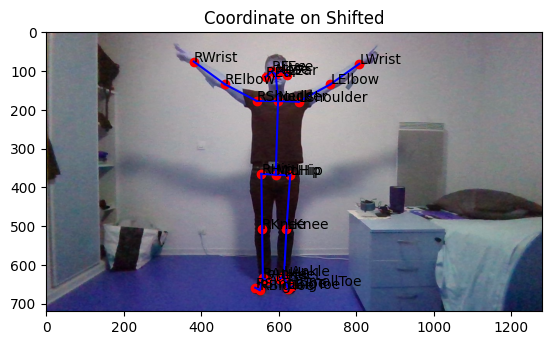

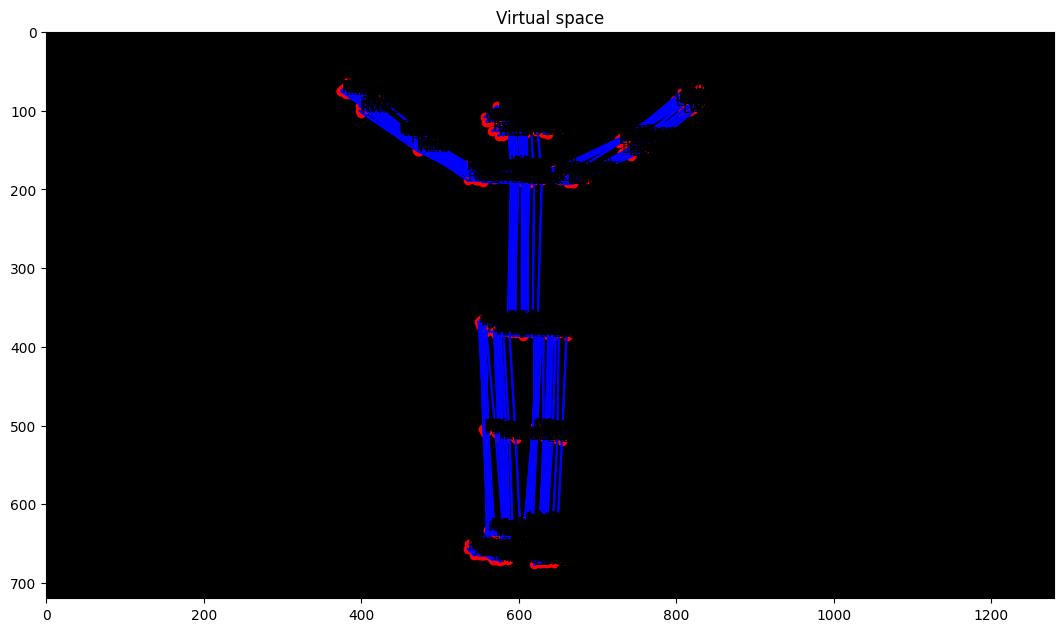

In [12]:
path='D:\Special_Project\openpose\output_json_folder\Train\Ludo'

X_Y_C_virtual_space(path)

# Display the distribution of the angles

In [13]:
def X_Y_C_joints(path, bp_joint, coor_bp):
    

    if os.path.isdir(path):
        len_filename = len(os.listdir(path))
        arr_joints = np.zeros((len_filename, len(coor_bp)))
        for j,filename in enumerate(os.listdir(path)):
            list_coord = extract_coord_list_k(path,filename, 0)
            X,Y,C = x_y_c(list_coord, 0)
            vect_bp, angle_cos, angle_sin = list_XY_err(coor_bp, X, Y, color='bleu')
            theta = angle(angle_cos, angle_sin)
            dict_angle = angle_joints(bp_joint, theta)

            for i, joints in enumerate(bp_joint):
                arr_joints[j, i] = dict_angle[str(joints)]

        df_joint = pd.DataFrame (arr_joints, columns = bp_joint)

    elif (os.path.isfile(path)):
        dir = os.path.split(path)[0]
        filename = os.path.split(path)[1]
        arr_joints = np.zeros((1, len(coor_bp)))
        list_coord = extract_coord_list_k(dir,filename, 0)
        X,Y,C = x_y_c(list_coord, 0)
        vect_bp, angle_cos, angle_sin = list_XY_err(coor_bp, X, Y, color='bleu')
        theta = angle(angle_cos, angle_sin)
        dict_angle = angle_joints(bp_joint, theta)

        for i, joints in enumerate(bp_joint):
            arr_joints[0, i] = dict_angle[str(joints)]

        df_joint = pd.DataFrame (arr_joints, columns = bp_joint)

    return df_joint,  arr_joints, (X,Y,C)

# REFERENCE

       Nose-Neck  Neck-LShoulder  LShoulder-LElbow  LElbow-LWrist  \
count  36.000000       36.000000         36.000000      36.000000   
mean    4.247928       89.338847        116.869998     125.068423   
std     1.331942        1.769159          1.803868       2.541731   
min     1.593556       87.628041        113.604952     121.685175   
25%     3.260345       87.954694        115.511730     123.251037   
50%     4.123162       88.158899        116.538872     124.242358   
75%     4.829655       89.991645        117.742134     126.197369   
max     6.836070       93.991420        122.218311     131.784290   

       Neck-RShoulder  RShoulder-RElbow  RElbow-RWrist  Neck-MidHip  \
count       36.000000         36.000000      36.000000    36.000000   
mean       -92.617873       -117.900956    -127.312491    -1.354164   
std          1.265446          1.705492       2.062491     0.828785   
min        -96.045309       -124.043414    -132.557569    -2.940113   
25%        -93.746267  

<AxesSubplot:>

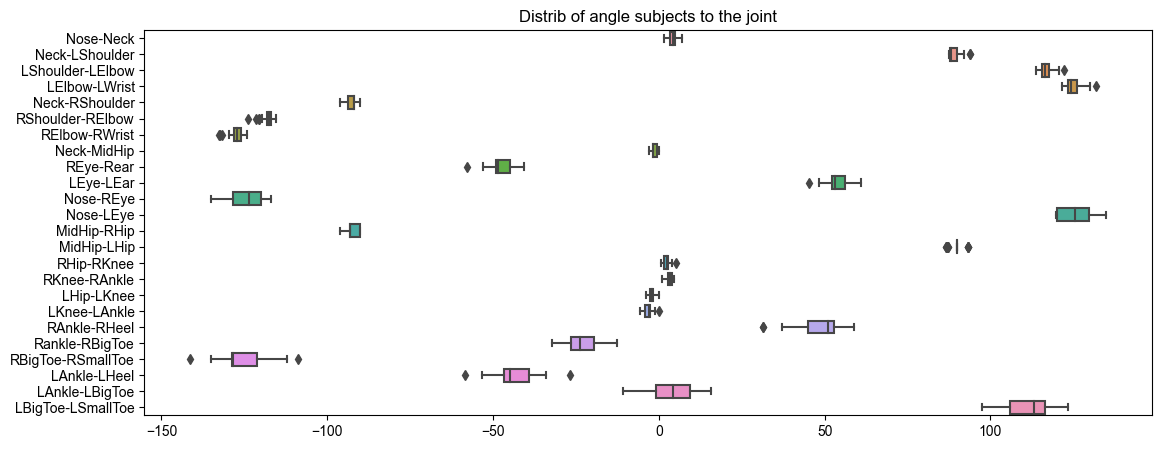

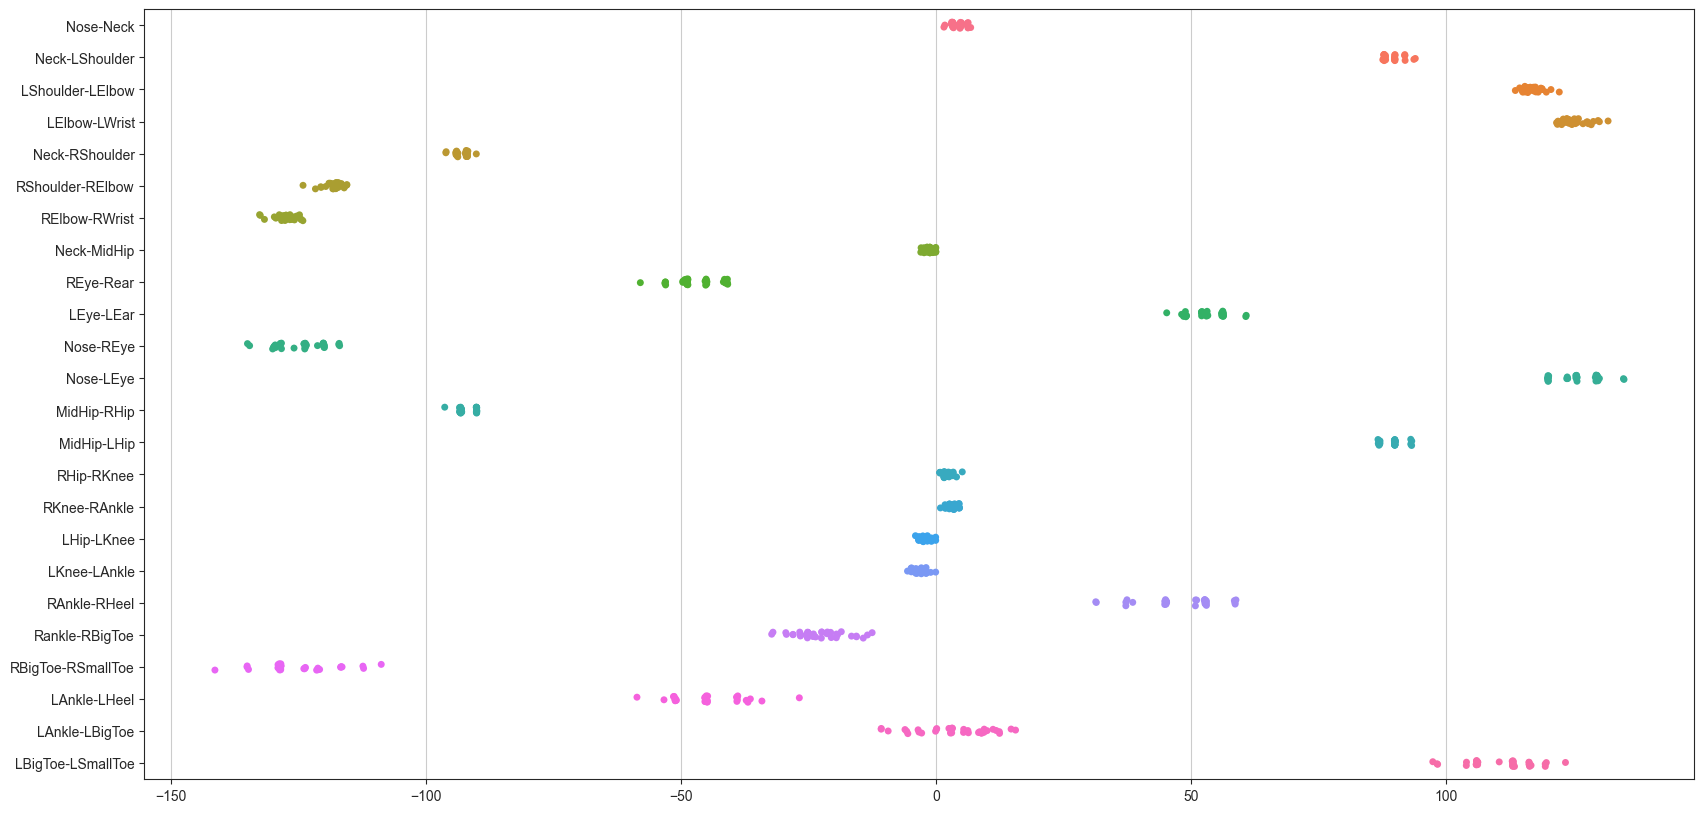

In [14]:
path='D:\Special_Project\openpose\output_json_folder\Train\Ludo'

df_joint_ref, _, _= X_Y_C_joints(path, bp_joint, coor_bp)
print(df_joint_ref.describe())


plt.figure(1, figsize=(13,5))
ax = sns.boxplot(data = df_joint_ref, orient = 'h').set(title='Distrib of angle subjects to the joint')
sns.set_style("ticks",{'axes.grid' : True})

plt.figure(2, figsize=(20,10))
sns.stripplot(data = df_joint_ref, orient = 'h')

# UPPER BODY REFERENCE

,Neck-LShoulder,LShoulder-LElbow,LElbow-LWrist,Neck-RShoulder,RShoulder-RElbow,RElbow-RWrist
0,87.976279,118.616260,125.435422,-90.077190,-117.644518,-126.189723
1,87.965284,117.542251,130.081916,-92.048433,-117.524317,-128.627818
2,89.977233,115.466560,122.957430,-92.090022,-117.121634,-127.859685
3,87.888828,115.071171,123.335018,-93.948686,-116.544052,-126.860516
4,89.951678,117.583548,124.457293,-91.978274,-119.585210,-126.891449
5,87.956457,117.049021,122.684646,-94.069083,-117.566581,-124.738279
6,87.964103,117.511784,125.175647,-92.102104,-116.544707,-124.332619
7,87.894303,114.446358,123.988902,-94.049995,-116.549103,-124.813321
8,87.779779,116.049308,121.858545,-92.220150,-118.081871,-125.719967
9,87.949407,116.530788,125.396199,-95.989837,-118.275955,-129.373328


array([[<AxesSubplot:title={'center':'Neck-LShoulder'}>,
        <AxesSubplot:title={'center':'LShoulder-LElbow'}>],
       [<AxesSubplot:title={'center':'LElbow-LWrist'}>,
        <AxesSubplot:title={'center':'Neck-RShoulder'}>],
       [<AxesSubplot:title={'center':'RShoulder-RElbow'}>,
        <AxesSubplot:title={'center':'RElbow-RWrist'}>]], dtype=object)

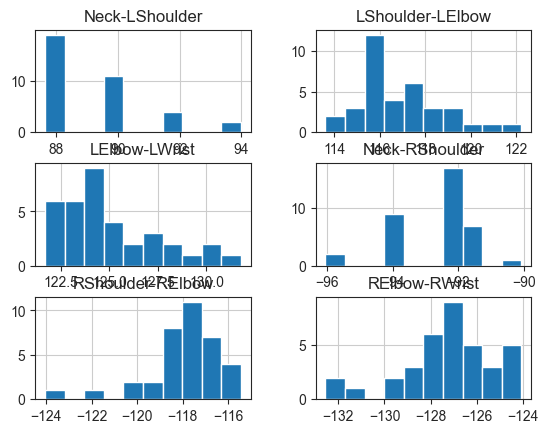

In [15]:
bp_joint_reduced = ['Neck-LShoulder', 'LShoulder-LElbow', 'LElbow-LWrist', 'Neck-RShoulder', 'RShoulder-RElbow', 'RElbow-RWrist']
coor_bp_reduced = [[1,5], [5,6], [6,7], [1,2], [2,3], [3,4]]

df_joint, _ ,_ = X_Y_C_joints(path, bp_joint_reduced , coor_bp_reduced)
display(df_joint)
df_joint.hist(bins=10)

# LARGE REPARTITION

       Neck-LShoulder  LShoulder-LElbow  LElbow-LWrist  Neck-RShoulder  \
count        7.000000          7.000000       7.000000        7.000000   
mean        86.523790        116.777092     119.548454      -94.119225   
std          1.049533          3.156164       2.300399        1.517003   
min         84.147343        113.215613     116.634890      -95.922830   
25%         86.857519        114.183836     117.422048      -95.634110   
50%         86.885374        115.731958     120.609692      -93.161907   
75%         86.951565        119.734564     121.294605      -92.883519   
max         87.015645        120.655273     122.161290      -92.714583   

       RShoulder-RElbow  RElbow-RWrist  
count          7.000000       7.000000  
mean        -114.883523    -117.821959  
std            2.514328       3.151623  
min         -118.217494    -121.604117  
25%         -116.176947    -120.245125  
50%         -114.983562    -118.345189  
75%         -113.968386    -115.041988  
max  

<AxesSubplot:>

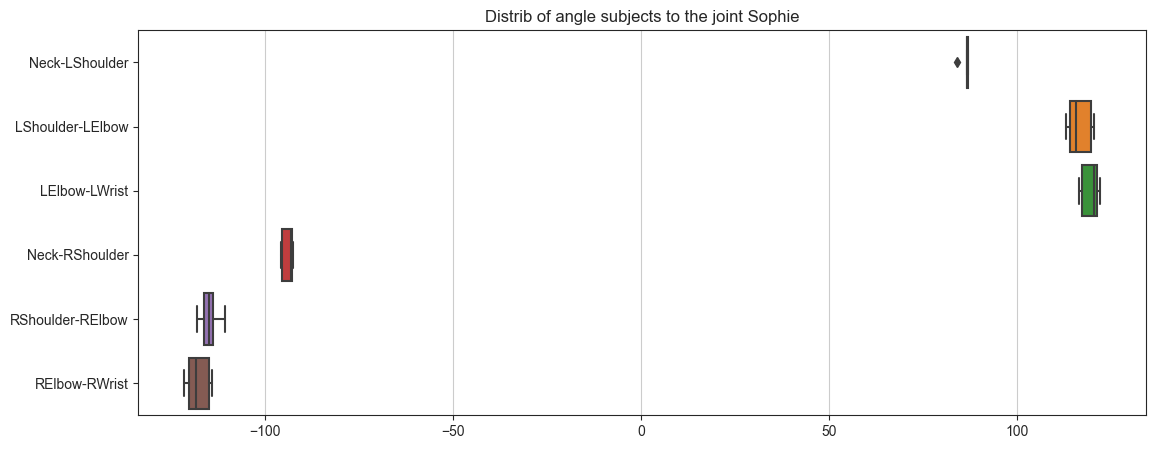

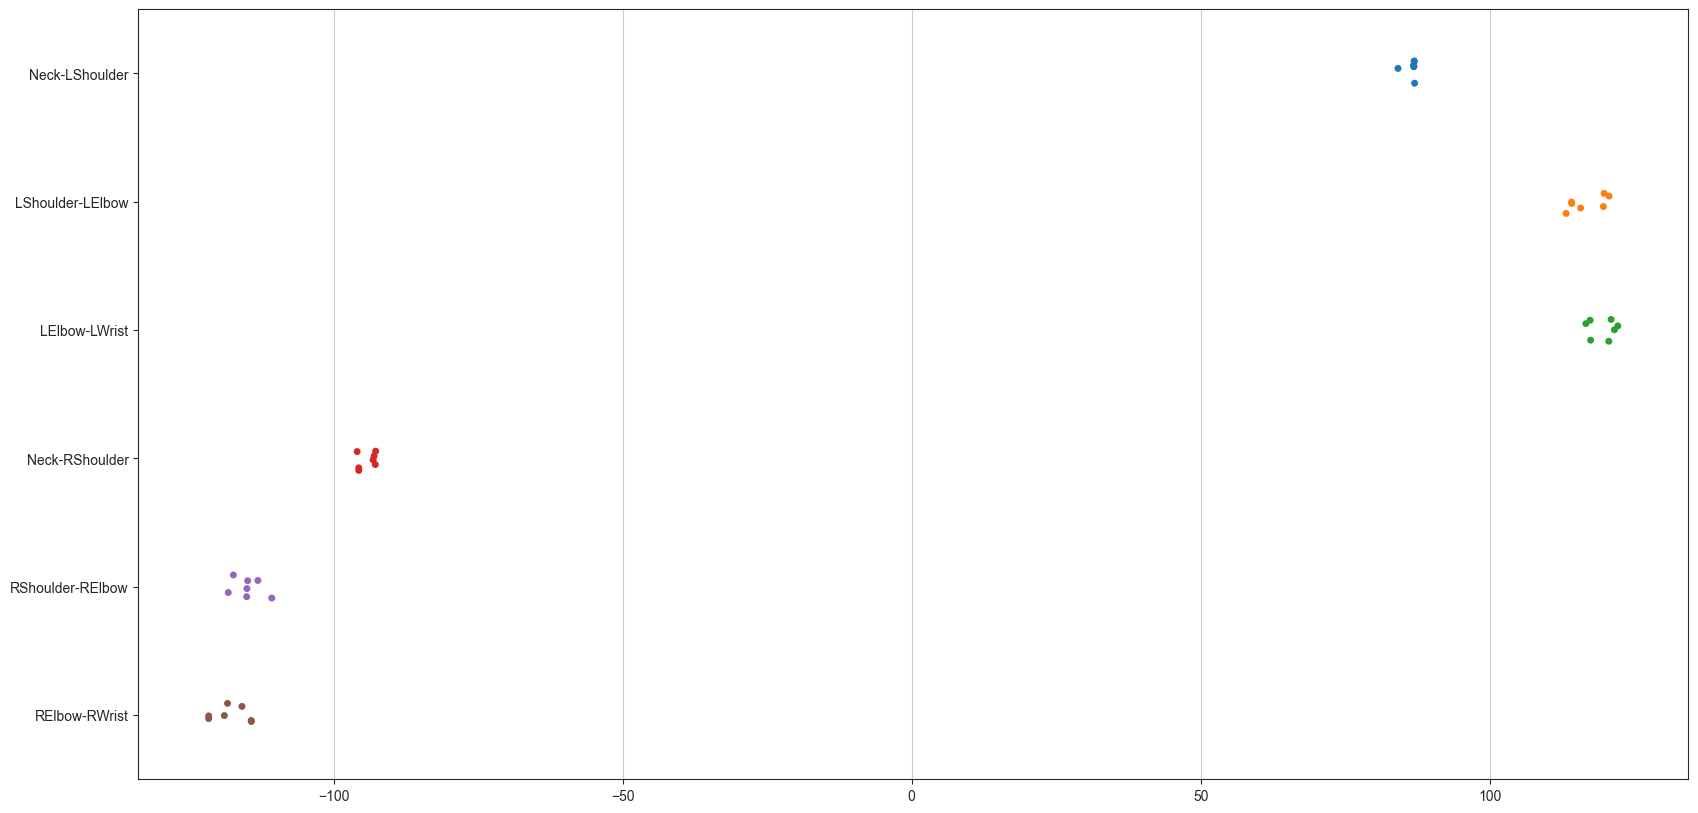

In [16]:
path_Sophie = 'D:\Special_Project\openpose\output_json_folder\Train\Sophie'
df_joint_large, _, _= X_Y_C_joints(path_Sophie, bp_joint_reduced , coor_bp_reduced)

print(df_joint_large.describe())

plt.figure(1, figsize=(13,5))
ax = sns.boxplot(data = df_joint_large, orient = 'h').set(title='Distrib of angle subjects to the joint Sophie')
sns.set_style("ticks",{'axes.grid' : True})

plt.figure(2, figsize=(20,10))
sns.stripplot(data = df_joint_large, orient = 'h')


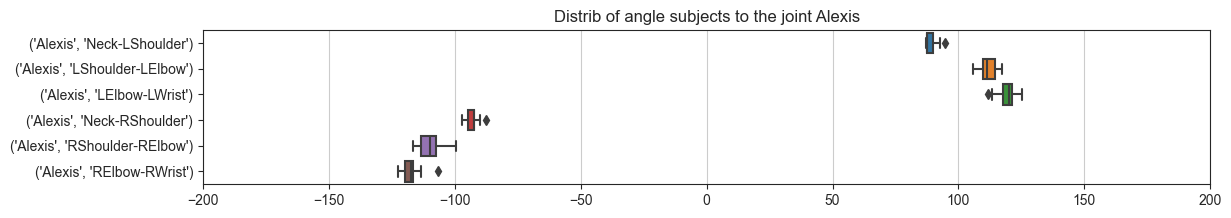

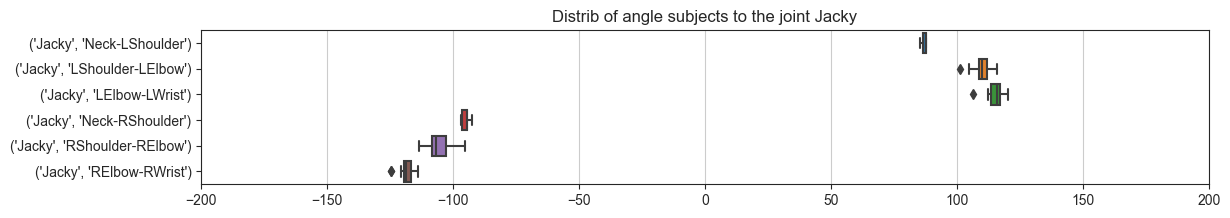

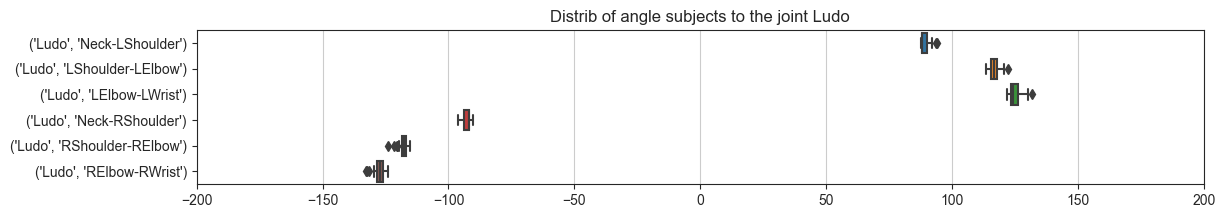

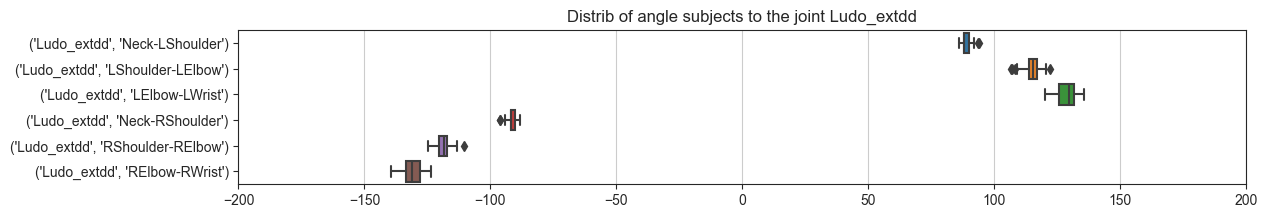

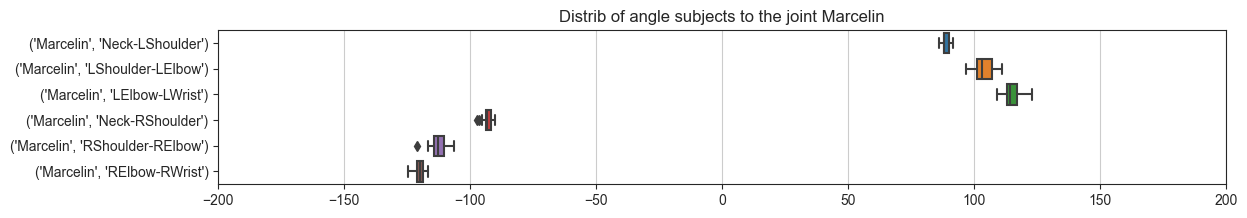

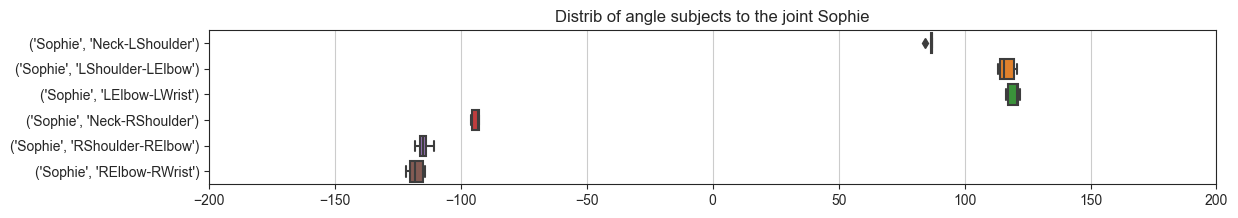

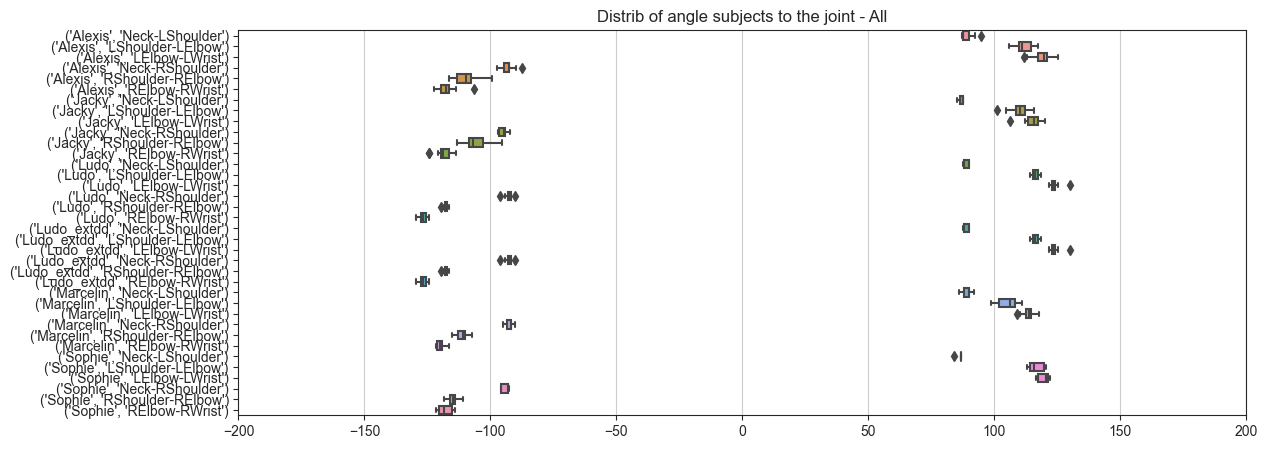

In [17]:

path_Train = 'D:\Special_Project\openpose\output_json_folder\Train'
list_folder = os.listdir(path_Train)

cols = pd.MultiIndex.from_product([list_folder, bp_joint_reduced])
df_final = pd.DataFrame(columns=cols)
final_list=[]

for k, name in enumerate(list_folder):
    path_filename = os.path.join(path_Train, name)
    df_joint, arr_joints, _ = X_Y_C_joints(path_filename, bp_joint_reduced , coor_bp_reduced)
    df_joint_reduced = pd.DataFrame(arr_joints, columns=cols[k*6:(k+1)*6])

    plt.figure(k, figsize=(13,2))
    ax = sns.boxplot(data = df_joint_reduced, orient = 'h').set(title='Distrib of angle subjects to the joint '+name)
    sns.set_style("ticks",{'axes.grid' : True})
    plt.xlim(-200,200)
    plt.show()

    df_final.loc[:, cols[k*6:(k+1)*6]] = df_joint_reduced 


plt.figure(10, figsize=(13,5))
ax = sns.boxplot(data = df_final, orient = 'h').set(title='Distrib of angle subjects to the joint ' + '- All')
sns.set_style("ticks",{'axes.grid' : True})
plt.xlim(-200,200)
plt.show()

    

# Towards normal distribution

In [18]:
def distrib_angle(path, bp_joint, coor_bp, df_ref, param1='mean', param2='std'):
    plt.figure(0, figsize=(13,15)) 
    df, _, (X,Y,C)= X_Y_C_joints(path, bp_joint, coor_bp)

    for joint in bp_joint: 
        mean = df_ref.describe().loc[param1, joint]
        std = df_ref.describe().loc[param2, joint]
        angle_joint = df.loc[0, df.columns==joint][0]
        if (angle_joint > mean-3*std) and(angle_joint < mean+3*std):
            elem = dict_joint_position[joint]
            plt.plot([X[elem[0]], X[elem[1]]],  [Y[elem[0]], Y[elem[1]]] , color='g')
                
        else:
            elem = dict_joint_position[joint]
            plt.plot([X[elem[0]], X[elem[1]]],  [Y[elem[0]], Y[elem[1]]] , color='r')
    
    
    plt.imshow(blank, cmap='gray')
    plt.title('Virtual space')
    

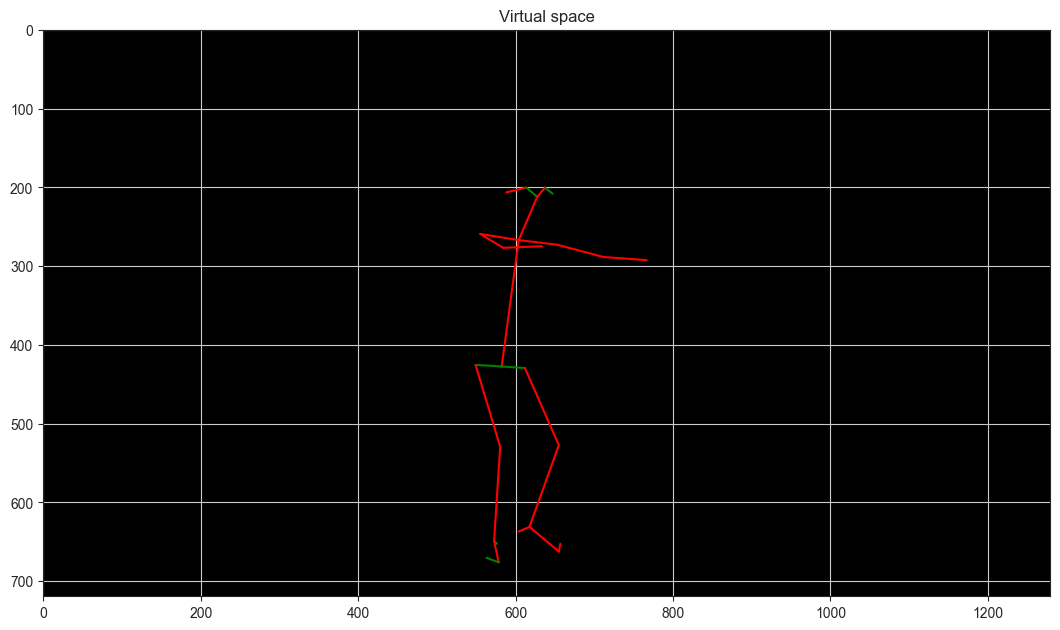

In [19]:
path_f =r'D:\Special_Project\openpose\output_json_folder\Test\Ludo\WIN_20221012_08_38_15_Pro_keypoints.json'
distrib_angle(path_f, bp_joint, coor_bp, df_joint_ref, param1='mean', param2='std')


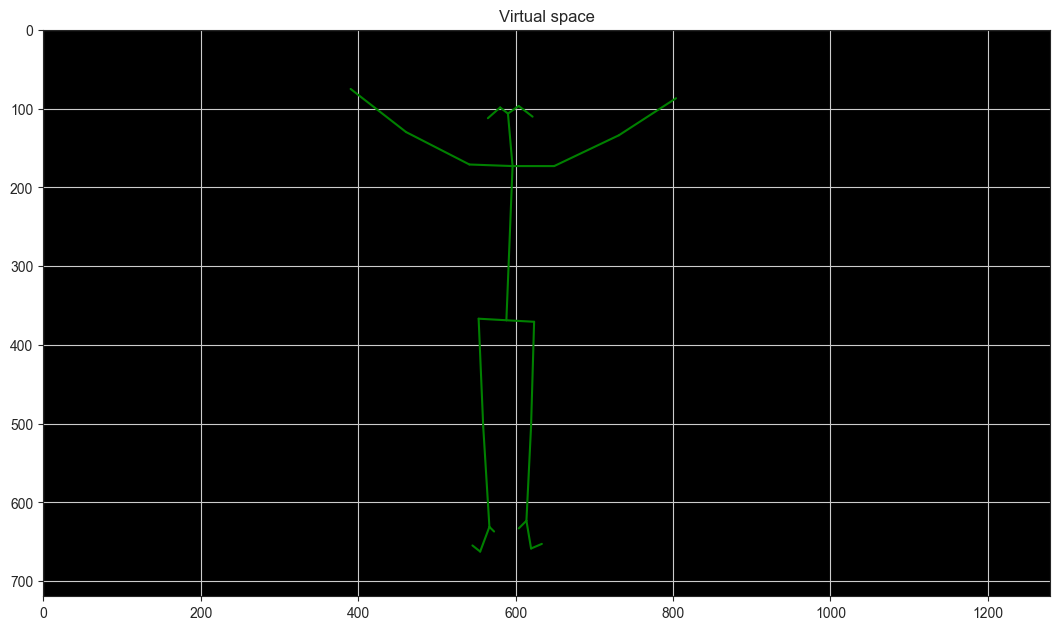

In [20]:
path_f1 =r'D:\Special_Project\openpose\output_json_folder\Train\Ludo\WIN_20220928_09_33_46_Pro_keypoints.json'
distrib_angle(path_f1, bp_joint, coor_bp, df_joint_ref, param1='mean', param2='std')


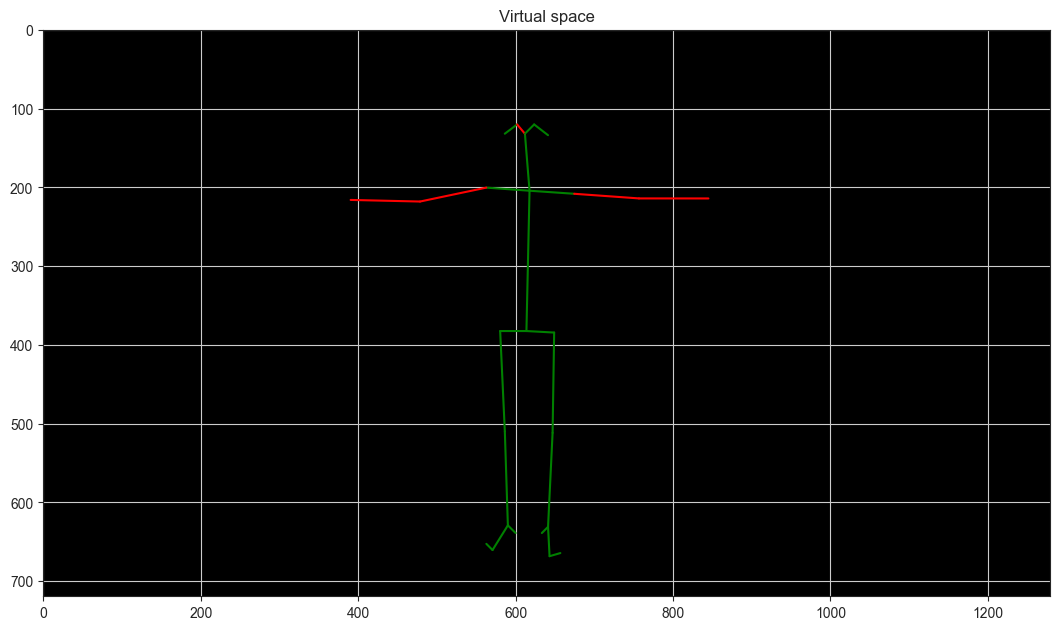

In [21]:
path_f1 =r'D:\Special_Project\openpose\output_json_folder\Test\Ludo\WIN_20221012_08_37_57_Pro_keypoints.json'
distrib_angle(path_f1, bp_joint, coor_bp, df_joint_ref, param1='mean', param2='std')


## Detect position